### Slab ocean analysis
This notebook collects various quick analyses to catalogue the behavior of slab ocean models.

In [4]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys

import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

#### Load data

In [40]:
# Pull fields relevant to the radiative analysis
fields = ['swdn_toa', 'swup_toa', 'olr', 'swdn_sfc', 'swup_sfc', 'lwdn_sfc', 'lwup_sfc', 't_surf', 'evap', 'precip']
# Pull paths for control and SWISHE experiments
pathnames = {'CTL': '/scratch/gpfs/GEOCLIM/gr7610/tiger3/AM4/test/AM4/work/CTL1990_C192.SLAB_40_tiger3_intelmpi_24_1152PE/POSTP/00210101.atmos_month.nc',
             'EXP': '/scratch/gpfs/GEOCLIM/gr7610/tiger3/AM4/test/AM4/work/CTL1990_swishe_C192.SLAB_40_tiger3_intelmpi_24_1152PE/POSTP/00170101.atmos_month.nc'}
# Get data and load it
data = {experiment_name: xr.open_dataset(pathname)[fields].load() for experiment_name, pathname in pathnames.items()}

#### Radiative budget, TOA
$R_\mathrm{TOA} = \left( R_\mathrm{SW, dn} - R_\mathrm{SW, up} - R_\mathrm{LW, up} \right)_\mathrm{TOA} $ (+ down)

In [41]:
for experiment_name in pathnames.keys():
    data[experiment_name]['netrad_toa'] = data[experiment_name]['swdn_toa'] - data[experiment_name]['swup_toa'] + data[experiment_name]['olr']

#### Radiative budget, surface
$R_\mathrm{sfc} = \left( -R_\mathrm{SW, dn} + R_\mathrm{SW, up} - R_\mathrm{LW, dn} + R_\mathrm{LW, up} \right)_\mathrm{sfc}$ (+ up)

In [42]:
for experiment_name in pathnames.keys():
    data[experiment_name]['netrad_sfc'] = -data[experiment_name]['swdn_sfc'] + data[experiment_name]['swup_sfc'] - data[experiment_name]['lwdn_sfc'] + data[experiment_name]['lwup_sfc']

#### Radiative budget, atmosphere
$R_\mathrm{net, atm} = R_\mathrm{TOA} + R_\mathrm{sfc}$

In [43]:
for experiment_name in pathnames.keys():
    data[experiment_name]['netrad_atm'] = data[experiment_name]['netrad_toa'] + data[experiment_name]['netrad_sfc']

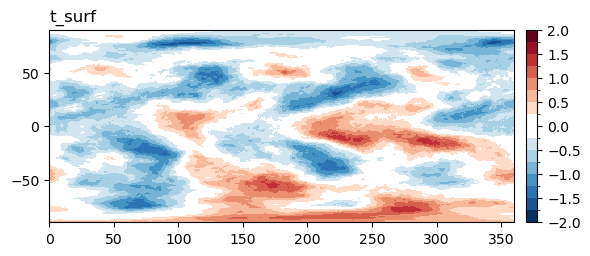

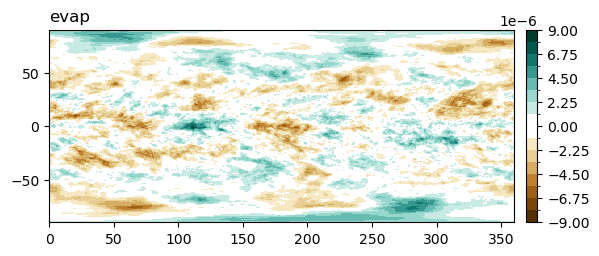

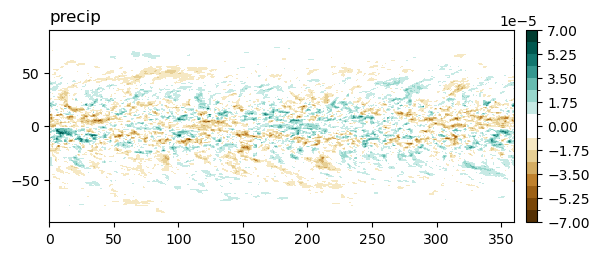

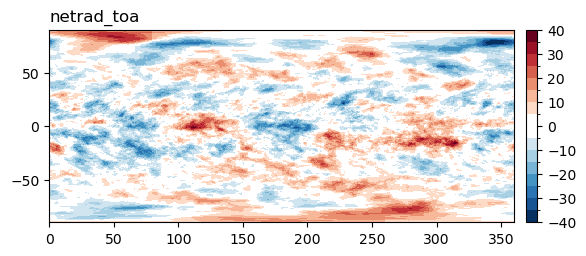

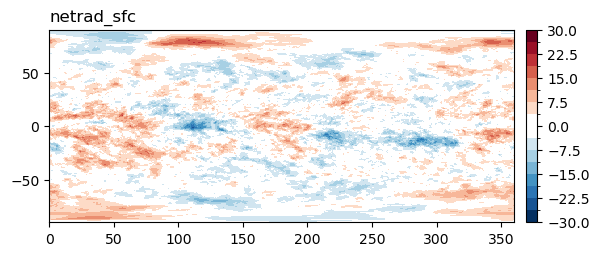

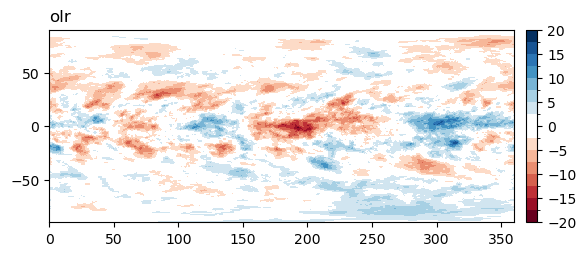

In [45]:
for field_name in ['t_surf', 'evap', 'precip', 'netrad_toa', 'netrad_sfc', 'olr']:

    difference = data['CTL'][field_name].mean('time') - data['EXP'][field_name].mean('time')
    norm, cmap = visualization.norm_cmap(difference, field=field_name)
    
    fig, ax = plt.subplots(figsize=(6, 2.5))
    im = ax.pcolormesh(difference.grid_xt, difference.grid_yt, difference,
                       norm=norm, cmap=cmap)
    
    cax = ax.inset_axes([1.025, 0, 0.025, 1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
    ax.set_title(field_name, loc='left', ha='left')